# Single Cell Optimisation exercise


**We are pleased to invite you to take part in an exciting challenge**

** In order to do that, you will modify:**
1. The **features** you want to optimize for.
2. The **parameters** of the model.
3. The **settings** of the optimisation (number of generations / individuals).


These are the rules and guidelines:
1. You **can change the features** you want to optimize for, we will provide a list of the allowed ones.
2. You are allowed to **change the model parameters**. You can use the number of fixed parameters that you want.
3. You are encouraged to report any problems in the **[chat channel](https://gitter.im/BlueBrain/SimulationTutorials)** dedicated to this tutorial and also to discuss possible ways to solve the problem.   
4. **Copy and paste the output** of the **last two cells** of this notebook in a **private chat** with [Elisabetta](https://gitter.im/elisabettai). We will accept results up to **Wednesday, April 26 at 23.59**.
5. Hint: **we will score** your model based on how much it **generalizes**.
6. **Have fun**.

Authors of this script:

Werner Van Geit @ Blue Brain Project

Elisabetta Iavarone @ Blue Brain Project

___
### Overview:

* In this exercise we will use the **Blue Brain Python Optimisation Library** [BluePyOpt](https://github.com/BlueBrain/BluePyOpt) to create a model template for the [NEURON simulator](https://www.neuron.yale.edu/neuron/) and to constrain the model parameters in order to try to reproduce the firing behavior of the "ShortPosStep" stimulus.

<IPython.core.display.Javascript object>


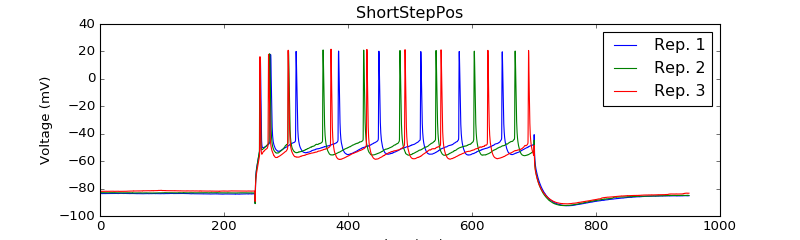

In [1]:
# TODO: execute this cell

%load_ext autoreload
%autoreload

import numpy
import json
import IPython
from json2html import *

import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['figure.figsize'] = 10, 10

import collections

import efel
import neurom

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

# Define the directory containing the voltage traces
data_dir = '../eFEL/data/'

# Store data in a dictionary step_name : [list of repetitions]
steps_dict = collections.OrderedDict({'ShortStepPos': []})

# Import the os Python module to interact with the operating system
import os
import glob


files_list = glob.glob1(data_dir, "*.dat")

# Store voltage data in a dictionary step_name : [list of repetitions]
steps_v_dict = collections.OrderedDict({'ShortStepPos': []})

for file_name in files_list:
    # Get channel and trace number from the file_name
    channel = int(file_name[:-4].split('_')[2][2:])
    tracenum = int(file_name[:-4].split('_')[-1])
    
    # Even channel numbers are voltage traces in this case
    if channel % 2 == 0:
        if "APWaveform" in file_name:
            steps_v_dict['ShortStepPos'].append(numpy.fromfile(os.path.join(data_dir,file_name)))

fig1, axes = plt.subplots(len(steps_v_dict), figsize = (10,3))

# Plot the voltage traces
for idx, step_name in enumerate(steps_v_dict.keys()):
    for rep, trace in enumerate(steps_v_dict[step_name]):
        data = trace.reshape(len(trace)/2,2)
        axes.plot(data[:,0],data[:,1], label = 'Rep. ' + str(rep+1))
        axes.set_ylabel('Voltage (mV)')
        axes.legend(loc = 'best')
        axes.set_title(step_name)
    axes.set_xlabel('Time (ms)')

# 2. Electrophysiological features

In this section you will choose the eFeatures you want to extract from the traces above. See [here](http://bluebrain.github.io/eFEL/eFeatures.html) for the description of some eFeatures.

In [2]:
# TODO: add in the row below the eFeatures you want to analyse
feature_names = ['time_to_first_spike', 'AP_width']
#feature_names = ['time_to_first_spike', 'AHP_depth', 'AP_width', 'AP_height', 'Spikecount', 'AP1_width', 'AP2_width']

# Extract features
import efel

# Define stimulus start and end times
steps_info = {'ShortStepPos': [250, 700]}

# Prepare the traces for eFEL
def get_features(data):
    # All the traces converted in eFEL format
    efel_traces = {'ShortStepPos': []}
    for step_name, step_traces in data.items():
        for rep in step_traces:
            data = rep.reshape(len(rep)/2,2)
            # A single eFEL trace 
            trace = {}
            trace['T'] = data[:,0]
            trace['V'] = data[:,1]
            trace['stim_start'] = [steps_info[step_name][0]]
            trace['stim_end'] = [steps_info[step_name][1]]
            trace['name'] = step_name
            
            efel_traces[step_name].append(trace)
    
    features_values = collections.defaultdict(dict)       
    
    features_values['ShortStepPos'] = efel.getMeanFeatureValues(efel_traces['ShortStepPos'], feature_names)                                                               
    mean_std_features = collections.defaultdict(lambda:collections.defaultdict(dict))
    for step_name in features_values:
        for efeature in features_values[step_name][0]:
            efeature_values = [x[efeature] for x in features_values[step_name]]
            mean_std_features[step_name][efeature] = {'mean': numpy.mean(efeature_values), 
                                                      'std': numpy.std(efeature_values)}
    
    return mean_std_features

mean_std_features = get_features(steps_v_dict)
IPython.display.HTML(json2html.convert(json=dict(mean_std_features)))

# 3. Model definition
Here you can modify which are free parameters and which are frozen. For the free parameters you can choose the ranges, for the frozen you can choose the value. Hint: why don't you use the result from the previous optimisation for the leak conductance?

In [3]:
morphology_file = 'simple.swc'
morphology = ephys.morphologies.NrnFileMorphology(morphology_file)

somatic_loc = ephys.locations.NrnSeclistLocation('somatic', seclist_name='somatic')

hh_mech = ephys.mechanisms.NrnMODMechanism(                                         
        name='hh',                                                                  
        suffix='hh',                                                                
        locations=[somatic_loc]) 
# Na+ conductance
gnabar_param = ephys.parameters.NrnSectionParameter(                                    
        name='gnabar_hh',                                                           
        param_name='gnabar_hh',                                                     
        locations=[somatic_loc],                                                    
        bounds=[0.0, 1.0],
        frozen=False) 
# K+ conductance
gkbar_param = ephys.parameters.NrnSectionParameter(                              
        name='gkbar_hh',                                                         
        param_name='gkbar_hh',                                                   
        bounds=[0.01, 1],
        locations=[somatic_loc],                                                 
        frozen=False) 
# Leak conductance (Passive membrane resistance)
gl_param = ephys.parameters.NrnSectionParameter(                                    
        name='gl_hh',                                                           
        param_name='gl_hh',                                                     
        locations=[somatic_loc],                                                    
        value=0.00005,
        frozen=True)
# Reversal potential of the leak conductance
el_param = ephys.parameters.NrnSectionParameter(                                    
        name='el_hh',                                                           
        param_name='el_hh',                                                     
        locations=[somatic_loc],                                                    
        value=-82,
        frozen=True)
# Membrane capacitance
cm_param = ephys.parameters.NrnSectionParameter(                                 
        name='cm',                                                               
        param_name='cm',                                                         
        value=2.0,                                                               
        locations=[somatic_loc],                                                 
        frozen=True)   
# Temperature (celsius)
celsius_param = ephys.parameters.NrnGlobalParameter(                                 
        name='celsius',                                                               
        param_name='celsius',                                                         
        value=34.0,                                                                 
        frozen=True)   
# Voltage at time 0
vinit_param = ephys.parameters.NrnGlobalParameter(                                 
        name='v_init',                                                               
        param_name='v_init',                                                         
        value=-82,                                                                 
        frozen=True)   
simple_cell = ephys.models.CellModel(                                            
        name='simple_cell',                                                      
        morph=morphology,                                                             
        mechs=[hh_mech],                                                         
        params=[cm_param, gnabar_param, gkbar_param, gl_param, el_param, celsius_param, vinit_param])   
print simple_cell

simple_cell:
  morphology:
    simple.swc
  mechanisms:
    hh: hh at ['somatic']
  params:
    cm: ['somatic'] cm = 2.0
    gnabar_hh: ['somatic'] gnabar_hh = [0.0, 1.0]
    gkbar_hh: ['somatic'] gkbar_hh = [0.01, 1]
    gl_hh: ['somatic'] gl_hh = 5e-05
    el_hh: ['somatic'] el_hh = -82
    celsius: celsius = 34.0
    v_init: v_init = -82



In [4]:
# Execute this cell
soma_loc = ephys.locations.NrnSeclistCompLocation(                               
        name='soma',                                                             
        seclist_name='somatic',                                                  
        sec_index=0,                                                             
        comp_x=0.5)         

# 4. Setting-up a simulation

Here you can see the responses with 0.5 S/cm$^2$ for the maximal conductance of the Na$^+$ current and 0.034 S/cm$^2$ for the K$^+$. Will the features and parameters you have chosen above improve the model responses? Hint: can these values for the maximal conductance of the Na$^+$ and K$^+$ can help you to better define the parameter ranges?

<IPython.core.display.Javascript object>


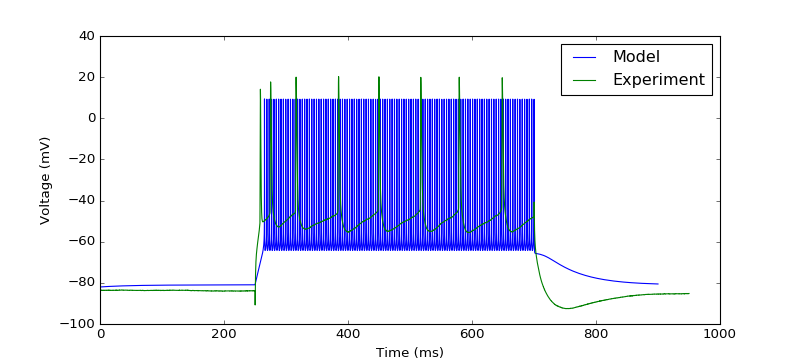

In [5]:
nrn = ephys.simulators.NrnSimulator()                                            

IDREST = .98
IV = -0.46
APWaveform = 0.85

sweep_protocols = []                                                             
for protocol_name, amplitude in [('step1', APWaveform)]:         
    stim = ephys.stimuli.NrnSquarePulse(                                         
                step_amplitude=amplitude,                                        
                step_delay=250,                                                  
                step_duration=450,                                                
                location=soma_loc,                                               
                total_duration=900)                                              
    rec = ephys.recordings.CompRecording(                                        
            name='%s.soma.v' % protocol_name,                                    
            location=soma_loc,                                                   
            variable='v')                                                        
    protocol = ephys.protocols.SweepProtocol(protocol_name, [stim], [rec])       
    sweep_protocols.append(protocol)                                             
twostep_protocol = ephys.protocols.SequenceProtocol('twostep', protocols=sweep_protocols)

default_params = {'gnabar_hh': 0.5, 'gkbar_hh': 0.034}
responses = twostep_protocol.run(cell_model=simple_cell, param_values=default_params, sim=nrn)

def plot_responses(responses):
    fig1, ax = plt.subplots(len(responses), figsize = (10,4.5))
    ax.plot(responses['step1.soma.v']['time'], responses['step1.soma.v']['voltage'], label='Model')
    data = steps_v_dict['ShortStepPos'][0].reshape(len(steps_v_dict['ShortStepPos'][0])/2,2)
    ax.plot(data[:, 0], data[:, 1], label='Experiment')
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.legend(loc="best")
plot_responses(responses)


In [24]:
# Run this cell and read the scores

efel_feature_means = {'step1': {feature_name: mean_std_features['ShortStepPos'][feature_name] 
                                for feature_name in feature_names}}
                                                                                 
objectives = []                                                                  
                                                                                 
for protocol in sweep_protocols:                                                 
    stim_start = protocol.stimuli[0].step_delay                                  
    stim_end = stim_start + protocol.stimuli[0].step_duration 
    for efel_feature_name, mean_std_dict in efel_feature_means[protocol.name].iteritems():
        mean = mean_std_dict['mean']
        std = mean_std_dict['std']
        feature_name = '%s.%s' % (protocol.name, efel_feature_name)              
        feature = ephys.efeatures.eFELFeature(                                   
                    feature_name,                                                
                    efel_feature_name=efel_feature_name,                         
                    recording_names={'': '%s.soma.v' % protocol.name},           
                    stim_start=stim_start,                                       
                    stim_end=stim_end,                                           
                    exp_mean=mean,                                               
                    exp_std=std)                                        
        objective = ephys.objectives.SingletonObjective(                         
            feature_name,                                                        
            feature)                                                             
        objectives.append(objective)                 
score_calc = ephys.objectivescalculators.ObjectivesCalculator(objectives)        

cell_evaluator = ephys.evaluators.CellEvaluator(                                 
        cell_model=simple_cell,                                                  
        param_names=['gnabar_hh', 'gkbar_hh'],                                   
        fitness_protocols={twostep_protocol.name: twostep_protocol},             
        fitness_calculator=score_calc,                                           
        sim=nrn) 

print 'Score of the features:\n'
print cell_evaluator.evaluate_with_dicts(default_params)                         


Score of the features:

{'step1.time_to_first_spike': 18.486784307441106, 'step1.AP_width': 18.485792645562608}


# 5. Parameters optimization 

Here you can modify the number of individuals ("offspring_size") in the population.

In [17]:
# Run this cell, you can change the offspring_size
optimisation = bpopt.optimisations.DEAPOptimisation(                              
        evaluator=cell_evaluator,                                                
        offspring_size = 15)    

Run the optimisation, you can modify the number of generations ("max_ngen") you want to run. This step may take some minutes, depending on the number of individuals and generations.

In [36]:
# Run this cell, you can modify "max_ngen". Once the optimisation is finished, 
final_pop, hall_of_fame, logs, hist = optimisation.run(max_ngen=10)

print 'Final population: \n', final_pop, "\n"                                            
best_ind = hall_of_fame[0]
"\n"                                                      
print 'Best individual: ', best_ind
print "\n"                                              
print 'Fitness values: ', best_ind.fitness.values             
print "\n"
print 'Best individual scores:'
best_ind_dict = cell_evaluator.param_dict(best_ind)                              
print cell_evaluator.evaluate_with_dicts(best_ind_dict)    

Final population: 
[[0.8473080587921191, 0.04729164235849165], [0.8249316861761996, 0.04729164235849165], [0.8249316861761996, 0.04729164235849165], [0.8249316861761996, 0.04729164235849165], [0.612983149457001, 0.05430529367641505], [0.821757579388619, 0.7580154901683739], [0.5859525647273465, 0.6432516241135887], [0.1980954533765037, 0.21316571955380553], [0.2031476963573397, 0.10462306222044594], [0.821757579388619, 0.7580154901683739], [0.821757579388619, 0.7580154901683739], [0.821757579388619, 0.7580154901683739], [0.2031476963573397, 0.10462306222044594], [0.6715275216153022, 0.6908663669635471], [0.7475804827454143, 0.3144738891082068], [0.821757579388619, 0.7580154901683739], [0.2031476963573397, 0.10462306222044594], [0.9637955188741637, 0.7092238571603401], [0.5859525647273465, 0.18027308110676848], [0.1980954533765037, 0.7341146327962794], [0.20809919779838693, 0.08468738858037811], [0.8167668704033679, 0.7807916962656535], [0.821757579388619, 0.8643623471651366], [0.821757

Plot the evolution of the features:

In [ ]:
# Run this cell
gen_numbers = logs.select('gen')
min_fitness = numpy.array(logs.select('min'))
max_fitness = logs.select('max')
mean_fitness = numpy.array(logs.select('avg'))
std_fitness = numpy.array(logs.select('std'))

fig, ax = plt.subplots(1, figsize=(8, 8), facecolor='white')

std = std_fitness
mean = mean_fitness
minimum = min_fitness
stdminus = mean - std                                                           
stdplus = mean + std

ax.plot(                                                                      
    gen_numbers,                                                                
    mean,                                                                       
    color='black',                                                              
    linewidth=2,                                                                
    label='population average')                                                 

ax.fill_between(                                                              
    gen_numbers,                                                                
    stdminus,                                                                   
    stdplus,                                                                    
    color='lightgray',                                                          
    linewidth=2,                                                                
    label=r'population standard deviation')                                     

ax.plot(                                                                      
    gen_numbers,                                                                
    minimum,                                                                    
    color='red',                                                                
    linewidth=2,                                                                
    label='population minimum')                                                 

ax.set_xlim(min(gen_numbers) - 1, max(gen_numbers) + 1)                       
ax.set_xlabel('Generation #')                                                 
ax.set_ylabel('# Experimental standard deviations')                                            
ax.set_ylim([0, max(stdplus)])                                                
ax.legend() 

Plotting the voltage responses:

In [ ]:
responses = twostep_protocol.run(cell_model=simple_cell, param_values=best_ind_dict, sim=nrn)
plot_responses(responses)


Once you are happy with your result, send the output of the two cells below to [Elisabetta](https://gitter.im/elisabettai).

In [22]:
# Run this cell and send the output
best_params = {}
for name in best_ind_dict:
    best_params[name] = best_ind_dict[name]
frozen_pars = [param.name for param in simple_cell.params.values() if param.frozen]
for name in frozen_pars:
    best_params[name] = simple_cell.params[name].value

pprint.pprint(best_params)



{'celsius': 34.0,
 'cm': 2.0,
 'el_hh': -82,
 'gkbar_hh': 0.017489173398683645,
 'gl_hh': 5e-05,
 'gnabar_hh': 0.9948626177108335,
 'v_init': -82}


In [23]:
# Run this cell and send the output
pprint.pprint(cell_evaluator.evaluate_with_dicts(best_ind_dict))

{'step1.AP_width': 17.12446357545991,
 'step1.time_to_first_spike': 4.751276340697479}
